In [17]:
import numpy as np
import matplotlib.pyplot as plt
from photovoltaic_modeling.parameter.parameter_extraction import ParameterExtraction



In [8]:
# http://www.posharp.com/msx120-solar-panel-from-bp-solar_p857364851d.aspx

# from manufacturer
I_sc = 3.87 # short circuit current
I_mpp = 3.56 # maximum power point current
V_mpp = 33.7 # maximum power point voltage
V_oc = 42.1  # open circuit voltage
N_s = 72 # number of cells in series
P_mpp = 120 
K_vt = -0.160 # Temperature Coefficient of V_oc %/Cº
K_it = 0.065  # Temperature Coefficient of I_sc %/Cº	 


# k_p = -0.5
T_stc = 25 + 273.4

E_c = 1.6022e-19 # Elementary charge
Boltzmann = 1.3806e-23 # Boltzmann constant


parameter_extraction = ParameterExtraction(I_sc, V_oc, I_mpp, V_mpp, number_of_cells_in_series = N_s)
initial_guess = [1,1000,1] # [series_resistance_estimate,shunt_resistance_estimate,diode_quality_factor_estimate]
parameter_extraction.calculate(initial_guess) 

R_s = parameter_extraction.series_resistance
R_sh = parameter_extraction.shunt_resistance
K_d = parameter_extraction.diode_quality_factor

print(R_s,R_sh,K_d)


0.5602447674925701 1862.1251868520048 1.3433275036477912


In [9]:
def i_eval(irrad,temp_deg,v):
    
    temp_k = temp_deg +273.4

    V_t = K_d*Boltzmann*T_stc/E_c
    V_oc_t = V_oc + K_vt*( temp_k - T_stc)

    I_rrad_sts = 1000

    I_sc_t = I_sc*irrad/I_rrad_sts*(1 + K_it/100*(temp_k - T_stc))
    I_0 = (I_sc - (V_oc_t - I_sc_t*R_s)/R_sh)*np.exp(-V_oc_t/(N_s*V_t))

    I_ph = (I_0*np.exp(V_oc_t/(N_s*V_t)) + V_oc_t/R_sh)*irrad/I_rrad_sts


    i = 2
    V = V_mpp
    for it in range(100):
        i = I_ph - I_0 * (np.exp((v + i*R_s)/(N_s*V_t))-1)-(v+i*R_s)/R_sh 

    if i <0: i = 0
    
    return i

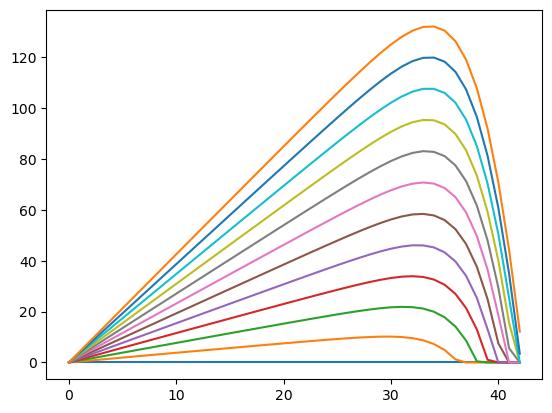

In [17]:

temp_deg = 25
v = 10
V = np.arange(0,V_oc,1.0)
I = np.zeros(len(V))

fig,axes = plt.subplots()

irrads = np.arange(0,1200,100.0)

for irrad in irrads:
    for it,v in enumerate(V):
        I[it] = i_eval(irrad,temp_deg,v)

    axes.plot(V,I*V)

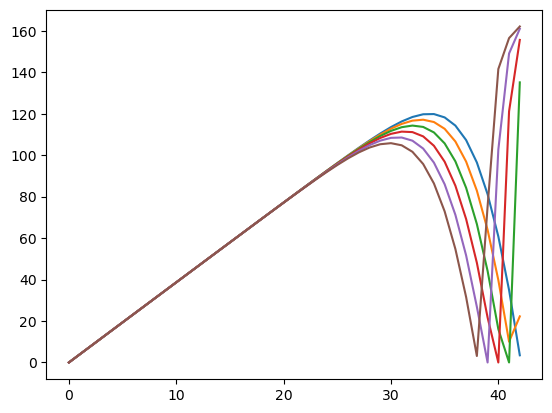

In [18]:
temp_deg = 25
V = np.arange(0,V_oc,1.0)
I = np.zeros(len(V))

fig,axes = plt.subplots()

temps_deg = np.arange(25,55,5)
irrad = 1000
for temp_deg in temps_deg:
    for it,v in enumerate(V):
        I[it] = i_eval(irrad,temp_deg,v)

    axes.plot(V,I*V)

In [1]:
import numpy as np
import sympy as sym
import pydae.build_cffi as db
import matplotlib.pyplot as plt


In [3]:
T_stc = 25 + 273.4
E_c = 1.6022e-19 # Elementary charge
Boltzmann = 1.3806e-23 # Boltzmann constant

params_dict = {str(I_sc):3.87,str(I_mpp):3.56,str(V_mpp):33.7,str(V_oc):42.1,str(N_s):72,str(K_vt):-0.160,str(K_it):0.065}
params_dict.update({str(R_s):0.5602,str(R_sh):1862,str(K_d):1.3433})


In [4]:
temp_k = temp_deg +273.4

V_t = K_d*Boltzmann*T_stc/E_c
V_oc_t = V_oc + K_vt*( temp_k - T_stc)

I_rrad_sts = 1000

I_sc_t = I_sc*irrad/I_rrad_sts*(1 + K_it/100*(temp_k - T_stc))
I_0 = (I_sc - (V_oc_t - I_sc_t*R_s)/R_sh)*sym.exp(-V_oc_t/(N_s*V_t))

I_ph = (I_0*sym.exp(V_oc_t/(N_s*V_t)) + V_oc_t/R_sh)*irrad/I_rrad_sts

eq_i = -i + I_ph - I_0 * (sym.exp((v + i*R_s)/(N_s*V_t))-1)-(v+i*R_s)/R_sh 
eq_p = -p + i*v


i = sym.Symbol(f'i_{name}', real=True)

dp_0 = sym.diff((I_ph - I_0 * (sym.exp((v + i*R_s)/(N_s*V_t))-1)-(v+i*R_s)/R_sh)*v,v)
v_mpp = sym.Symbol(f'v_mpp_{name}', real = True)
eq_v_mpp = dp_0.subs(v,v_mpp)

u_ini_dict = {f'v_{name}':30,f'irrad_{name}':1000,f'temp_deg_{name}':25}  # input for the initialization problem
u_run_dict = {f'v_{name}':30,f'irrad_{name}':1000,f'temp_deg_{name}':25}  # input for the running problem, its value is updated

h_dict = {'I_ph_{name}':I_ph}


sys_dict = {'name':'pv_dev',
            'params_dict':params_dict,
            'f_list':[],
            'g_list':[eq_i,eq_p,eq_v_mpp],
            'x_list':[ ],
            'y_ini_list':[i,p,v_mpp],
            'y_run_list':[i,p,v_mpp],
            'u_ini_dict':u_ini_dict,
            'u_run_dict':u_run_dict,
            'h_dict':h_dict}

bldr = db.builder(sys_dict)
bldr.build()

system without dynamic equations, adding dummy dynamic equation


In [5]:
eq_v_mpp

irrad_*((I_sc_ - (-I_sc_*R_s_*irrad_*(K_it_*(temp_deg_ - 25.0)/100 + 1)/1000 + K_vt_*(temp_deg_ - 25.0) + V_oc_)/R_sh_)*exp(38.8910832178883*(-K_vt_*(temp_deg_ - 25.0) - V_oc_)/(K_d_*N_s_))*exp(38.8910832178883*(K_vt_*(temp_deg_ - 25.0) + V_oc_)/(K_d_*N_s_)) + (K_vt_*(temp_deg_ - 25.0) + V_oc_)/R_sh_)/1000 + v_mpp_*(-1/R_sh_ - 38.8910832178883*(I_sc_ - (-I_sc_*R_s_*irrad_*(K_it_*(temp_deg_ - 25.0)/100 + 1)/1000 + K_vt_*(temp_deg_ - 25.0) + V_oc_)/R_sh_)*exp(38.8910832178883*(-K_vt_*(temp_deg_ - 25.0) - V_oc_)/(K_d_*N_s_))*exp(38.8910832178883*(R_s_*i_ + v_mpp_)/(K_d_*N_s_))/(K_d_*N_s_)) - (I_sc_ - (-I_sc_*R_s_*irrad_*(K_it_*(temp_deg_ - 25.0)/100 + 1)/1000 + K_vt_*(temp_deg_ - 25.0) + V_oc_)/R_sh_)*(exp(38.8910832178883*(R_s_*i_ + v_mpp_)/(K_d_*N_s_)) - 1)*exp(38.8910832178883*(-K_vt_*(temp_deg_ - 25.0) - V_oc_)/(K_d_*N_s_)) - (R_s_*i_ + v_mpp_)/R_sh_

In [6]:
import pv_dev

In [7]:
model = pv_dev.model()
model.ini({'v_':30},35)
model.report_y()

i_    =  3.78
p_    = 113.53
v_mpp_ = 33.34


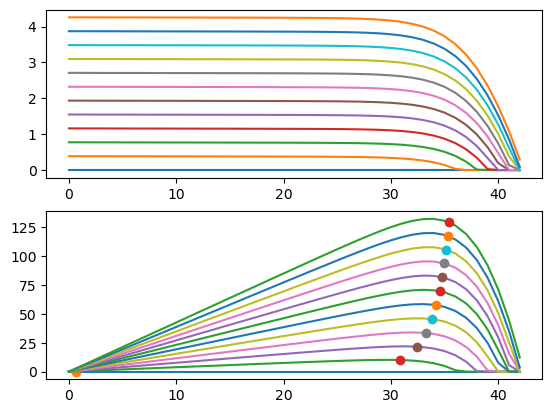

In [8]:
temp_deg = 25
v = 10
V = np.arange(0,42.1,1.0)
I = np.zeros(len(V))

fig,axes = plt.subplots(nrows=2)

irrads = np.arange(0,1200,100.0)

for irrad in irrads:
    for it,v in enumerate(V):
        model.ini({'v_':v,'irrad_':irrad,'temp_deg_':temp_deg},33)
        I[it] = np.clip(model.get_value('i_'),0,100)
    v_mpp_ = model.get_value('v_mpp_')
    model.ini({'v_':v_mpp_,'irrad_':irrad,'temp_deg_':temp_deg},33)


    axes[0].plot(V,I)
    axes[1].plot(V,V*I)
    axes[1].plot(v_mpp_,model.get_value('p_'),'o')

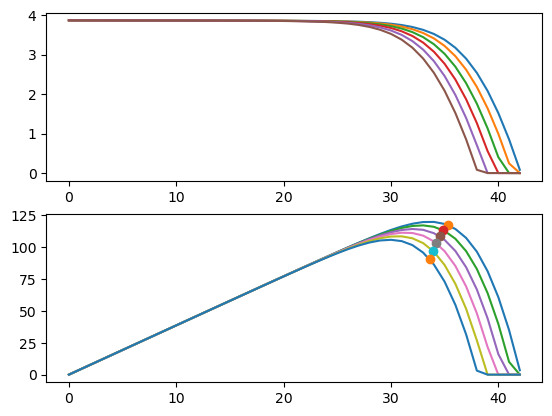

In [9]:
temp_deg = 25
V = np.arange(0,42.1,1.0)
I = np.zeros(len(V))

fig,axes = plt.subplots(nrows=2)

temps_deg = np.arange(25,55,5)
irrad = 1000
for temp_deg in temps_deg:
    for it,v in enumerate(V):
        model.ini({'v_':v,'irrad_':irrad,'temp_deg_':temp_deg},33)
        I[it] = np.clip(model.get_value('i_'),0,100)
    v_mpp_ = model.get_value('v_mpp_')
    model.ini({'v_':v_mpp_,'irrad_':irrad,'temp_deg_':temp_deg},30)


    axes[0].plot(V,I)
    axes[1].plot(V,V*I)
    axes[1].plot(v_mpp_,model.get_value('p_'),'o')

v_mpp = 35.500, p = 62.254


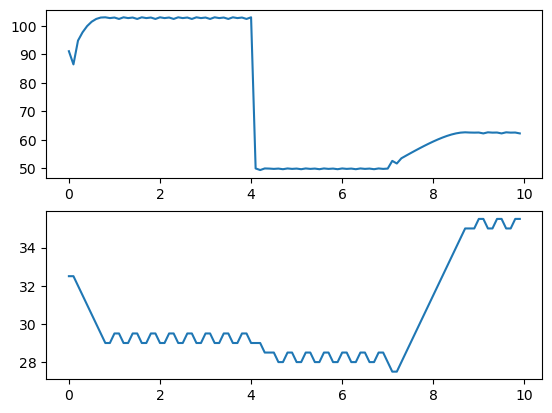

In [35]:
DV = 0.5
v_mpp = 32.0
p_mpp = 10
irrad = 1e3
temp_deg = 55

times = np.arange(0,10,0.1)
P = np.zeros(len(times))
V = np.zeros(len(times))
I = np.zeros(len(times))

for it,t in enumerate(times):

    v_mpp = DV + v_mpp

    if t>4: irrad = 500.0
    if t>7: temp_deg = 10.0

    model.ini({'v_':v_mpp,'irrad_':irrad,'temp_deg_':temp_deg},30)

    p = model.get_value('p_')

    if p > p_mpp:
        p_mpp = p
        DV = 1*DV
    else:
        p_mpp = p
        v_mpp =-DV + v_mpp
        DV = -1*DV
    V[it] = v_mpp
    P[it] = p

print(f'v_mpp = {v_mpp:4.3f}, p = {p:4.3f}')


fig,axes = plt.subplots(nrows=2)
axes[0].plot(times,P)
axes[1].plot(times,V)

32.0 3.0
0.5 -1.3104057281769363
-0.5 1.1125823870627856
-0.5 0.16004343074029093
-0.5 0.13926629531074886
-0.5 0.12028025572231105
-0.5 0.10316086951310544
-0.5 0.08791650894372616
-0.5 0.07449734631044524
-0.5 0.06280761045406447
0.5 0.052719014387855534
0.5 -0.052719014387855534
0.5 -0.06280761045406447
-0.5 -0.07449734631044524
0.5 0.07449734631044524
0.5 -0.07449734631044524
-0.5 -0.08791650894372616
0.5 0.08791650894372616
0.5 -0.08791650894372616
-0.5 -0.10316086951310544
0.5 0.10316086951310544
0.5 -0.10316086951310544
-0.5 -0.12028025572231105
0.5 0.12028025572231105
0.5 -0.12028025572231105
-0.5 -0.13926629531074886
0.5 0.13926629531074886
0.5 -0.13926629531074886
-0.5 -0.16004343074029093
0.5 0.16004343074029093
0.5 -0.16004343074029093
-0.5 -0.18246524565639044
0.5 0.18246524565639044
0.5 -0.18246524565639044
-0.5 -0.20631753639994033
0.5 0.20631753639994033
0.5 -0.20631753639994033
-0.5 -0.23132845519231005
0.5 0.23132845519231005
0.5 -0.23132845519231005
-0.5 -0.257184704

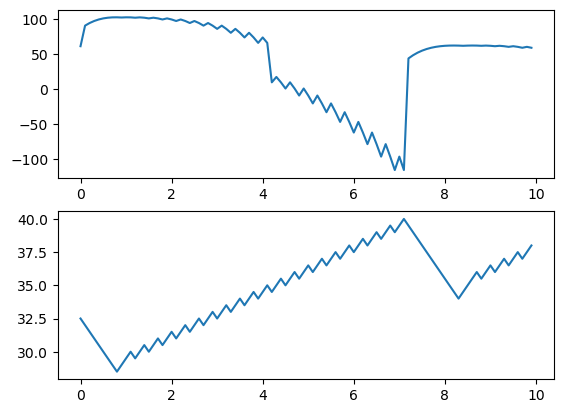

In [49]:
DV = 0.5
v_mpp = 32.0
p_mpp = 10
irrad = 1e3
temp_deg = 55

times = np.arange(0,10,0.1)
P = np.zeros(len(times))
V = np.zeros(len(times))
I = np.zeros(len(times))

i = 3.0
i_prev = 0.0
v_prev = 0.0
D = 1
for it,t in enumerate(times):

    Dv = v_mpp - v_prev
    Di = i - i_prev

    v_prev = v_mpp 
    i_prev = i

    if t>4: irrad = 500.0
    if t>7: temp_deg = 10.0


    i = model.get_value('i_')
    p = model.get_value('p_')
    v = model.get_value('v_')

    print(Dv,Di)
    if not Dv == 0.0:
        if Di/Dv > -i/v:
            v_mpp = v_mpp + DV
        else:
            v_mpp = v_mpp - DV
    else:
        D = -1*D
        v_mpp += 0.001*D


    model.ini({'v_':v_mpp,'irrad_':irrad,'temp_deg_':temp_deg},30)
    
    V[it] = v_mpp
    P[it] = p

print(f'v_mpp = {v_mpp:4.3f}, p = {p:4.3f}')


fig,axes = plt.subplots(nrows=2)
axes[0].plot(times,P)
axes[1].plot(times,V)

In [1]:
800/30

26.666666666666668